In [27]:
import pandas as pd

df = pd.read_csv('/home/selinawisco/asr_ssd_main/0421_44_eval.csv')
df_missed = df[df['new_label'] != df['pred_by_ASR']]

In [28]:
old_df= df[df['age']>5]
old_df['new_label'].value_counts()

new_label
0    1355
1     300
Name: count, dtype: int64

In [29]:
young_df= df[df['age']<=5]
young_df['new_label'].value_counts()

new_label
0    1513
1    1162
Name: count, dtype: int64

원래 어떻게 하는지
어떤 부분을 ASR 로 바꾼다 (원래 병원 방법) -> 베이스라인
개선방법
최종판단

클래스 임발란스
단어 틀린 거 별로 비율 loss weighting

In [30]:
train = pd.read_csv('/data/selinawisco/kochild/r08.1_train.csv')
train['new_label'].value_counts()

new_label
0    10826
1     5840
Name: count, dtype: int64

In [50]:
train_old = train[train['age']>5]
train_old['new_label'].value_counts()

new_label
0    5198
1    1057
Name: count, dtype: int64

In [51]:
train_young = train[train['age']<=5]
train_young['new_label'].value_counts()

new_label
0    5628
1    4783
Name: count, dtype: int64

In [31]:
# # Human vs Target text, 휴먼과 타겟전사 사이의 CER 구하기 'human_target_CER'
import jiwer
# CER 계산
def calculate_row_cer(row):
    reference = row['human_text_jamo']
    hypothesis = row['target_text_jamo']
    
    return jiwer.cer(reference, hypothesis)

### 0. 새 칼럼 추가 (1): human_target_CER (2): human_target_CER

In [32]:
# # Human vs Target text, 휴먼과 타겟전사 사이의 CER 구하기 'human_target_CER'
# import jiwer
# # CER 계산
# def calculate_row_cer(row):
#     reference = row['human_text_jamo']
#     hypothesis = row['target_text_jamo']
    
#     return jiwer.cer(reference, hypothesis)

# df['human_target_CER']=df.apply(lambda x: calculate_row_cer(x), axis=1)
# # df

In [33]:
import os
path = df.iloc[0]['audio']
parts = os.path.normpath(path).split(os.sep)
parts[6]

'일반_clear'

In [34]:
# 음성 배경 clear/noise 레이블 추가 -> 'background'
import regex as re
 
def is_clear(path):
    # path = row['audio']
    # print(path)
    match = re.search(r'^(?:[^\/]*\/){6}([^\/]*)', path).group(0)
    match = re.search(r'_(.*)',match)
    if match:
        label = match.group(1)
        
    else:
        label = 'clear'

    return True if label=='clear' else False

df['background'] = df['audio'].apply(lambda x: 'clear' if is_clear(x) else 'noise')

In [35]:
df.to_csv('/home/selinawisco/asr_ssd_main/0421_44_eval.csv')
df = pd.read_csv('/home/selinawisco/asr_ssd_main/0421_44_eval.csv')

In [36]:
# young (5세 이하) 와 old (6세 이상) 으로 데이터프레임 구분
df_young = df[df['age']<=5]
df_old = df[df['age']>5]

In [37]:
# 틀린 dataframe 에서 young (5세 이하) 와 old (6세 이상) 으로 데이터프레임 구분
df_missed_young = df_missed[df_missed['age']<=5]
df_missed_old = df_missed[df_missed['age']>5]

## 배경소음에 따른 CER 차이

### 나이별 배경소음 분포

In [38]:
df.groupby('age')['background'].value_counts()

age  background
2    clear          92
     noise          66
3    noise         394
     clear         333
4    noise         627
     clear         418
5    noise         424
     clear         321
6    clear         387
     noise         211
7    noise         354
     clear         166
8    clear         236
     noise         125
9    clear         131
     noise          12
10   clear          32
     noise           1
Name: count, dtype: int64

In [39]:
print('5세 이하: ',df_young['background'].value_counts(), '\n')
print('6세 이상: ', df_old['background'].value_counts(), '\n')

print(f'5세 이하 음성 중 {float(1511/(1511+1164))}% 가 noise')
print(f'6세 이상 음성 중 {float(952/(952+703))}% 가 noise')

5세 이하:  background
noise    1511
clear    1164
Name: count, dtype: int64 

6세 이상:  background
clear    952
noise    703
Name: count, dtype: int64 

5세 이하 음성 중 0.5648598130841122% 가 noise
6세 이상 음성 중 0.575226586102719% 가 noise


### ASR 의 CER

In [40]:
print(df_old['CER'].mean())
df_young['CER'].mean()

0.09333237423871865


0.2262128494558401

In [41]:
print('전체')
print('배경소음 없음: ', df[df['background']=='clear']['CER'].mean())
print('배경소음 있음: ', df[df['background']=='noise']['CER'].mean())

전체
배경소음 없음:  0.1495600414078675
배경소음 있음:  0.20014245891617166


In [42]:
print('ASR이 틀린 음성들 중')
print('배경소음 없음: ', df_missed[df_missed['background']=='clear']['CER'].mean())
print('배경소음 있음: ', df_missed[df_missed['background']=='noise']['CER'].mean())

ASR이 틀린 음성들 중
배경소음 없음:  0.31260677466863035
배경소음 있음:  0.4068428440246622


In [43]:
df_noise_young = df_young[df_young['background']=='noise']
print('5세 이하 noise 평균 CER: ', df_noise_young['CER'].mean())

df_clear_young = df_young[df_young['background']=='clear']
print('5세 이하 clear 평균 CER: ', df_clear_young['CER'].mean())



5세 이하 noise 평균 CER:  0.2356795715498561
5세 이하 clear 평균 CER:  0.2139240031636939


In [44]:
df_noise_old = df_old[df_old['background']=='noise']
df_noise_old['CER'].mean()
print('6세 이상 noise 평균 CER: ', df_noise_old['CER'].mean())

df_clear_old = df_old[df_old['background']=='clear']
df_clear_old['CER'].mean()
print('6세 이상 clear 평균 CER: ', df_clear_old['CER'].mean())


6세 이상 noise 평균 CER:  0.12376041454988822
6세 이상 clear 평균 CER:  0.07086292850473522


In [45]:
print('ASR이 틀린 음성들 중 5세 이하 ASR 의 CER:')
print('배경소음 없음: ', df_missed_young[df_missed_young['background']=='clear']['CER'].mean(),  len(df_missed_young[df_missed_young['background']=='clear']), '개')
print('배경소음 있음: ', df_missed_young[df_missed_young['background']=='noise']['CER'].mean(), len(df_missed_young[df_missed_young['background']=='noise']), '개')

ASR이 틀린 음성들 중 5세 이하 ASR 의 CER:
배경소음 없음:  0.34489930892992116 294 개
배경소음 있음:  0.417721602447451 383 개


In [46]:
# 틀린 음성들 중 6세 이상 아동의 배경소음에 따라 평균 휴먼 타겟 CER 
print('ASR이 틀린 음성들 중 6세 이상 ASR 의 CER:')
print('배경소음 없음: ', df_missed_old[df_missed_old['background']=='clear']['CER'].mean())
print('배경소음 있음: ', df_missed_old[df_missed_old['background']=='noise']['CER'].mean())

ASR이 틀린 음성들 중 6세 이상 ASR 의 CER:
배경소음 없음:  0.26289994182664334
배경소음 있음:  0.3818933561448532


### 배경소음이 있을때 ASR CER 이 높다 (음성인식하기가 어렵다)

### 휴먼 <-> 타겟의 CER

In [47]:
print('(5세 이하) 휴먼과 타겟의 차이(CER):')
print('배경소음 없음: ', df_missed_young[df_missed_young['background']=='clear']['human_target_CER'].mean(),  len(df_missed_young[df_missed_young['background']=='clear']), '개')
print('배경소음 있음: ', df_missed_young[df_missed_young['background']=='noise']['human_target_CER'].mean(), len(df_missed_young[df_missed_young['background']=='noise']), '개')

(5세 이하) 휴먼과 타겟의 차이(CER):


KeyError: 'human_target_CER'

In [ ]:
print('(6세 이상) 휴먼과 타겟의 차이(CER):')
print('배경소음 없음: ', df_missed_old[df_missed_old['background']=='clear']['human_target_CER'].mean(),  len(df_missed_old[df_missed_old['background']=='clear']), '개')
print('배경소음 있음: ', df_missed_old[df_missed_old['background']=='noise']['human_target_CER'].mean(), len(df_missed_old[df_missed_old['background']=='noise']), '개')

(6세 이상) 휴먼과 타겟의 차이(CER):
배경소음 없음:  0.16105086013462974 191 개
배경소음 있음:  0.11750071285999429 167 개


## 나이별 평균 CER

In [ ]:
df.groupby('age')['human_target_CER'].mean()

age
2     0.303602
3     0.224187
4     0.178342
5     0.095007
6     0.089887
7     0.047299
8     0.032450
9     0.033142
10    0.018939
Name: human_target_CER, dtype: float64

### 발음을 틀린 음성 중 휴먼<->타겟 CER 

In [ ]:
df_1 = df[df['new_label']==1]
df_1.groupby('age')['human_target_CER'].mean()

age
2     0.479690
3     0.435786
4     0.397371
5     0.323197
6     0.329769
7     0.315324
8     0.285714
9     0.315952
10    0.208333
Name: human_target_CER, dtype: float64

### 발음을 틀린 음성 중 ASR 의 CER

<AxesSubplot:xlabel='age'>

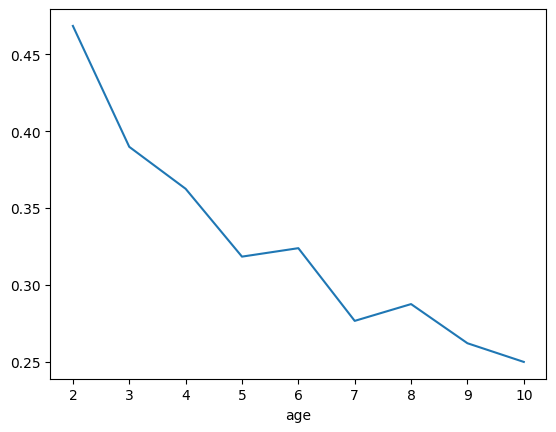

In [ ]:
df_1.groupby('age')['CER'].mean().plot()

### ASR 이 못 맞춘 음성 중에 나이별로 ASR 의 CER


In [ ]:
df_missed.groupby('age')['CER'].mean()

age
2     0.406250
3     0.393082
4     0.402893
5     0.358769
6     0.328930
7     0.345099
8     0.261226
9     0.283109
10    0.252976
Name: CER, dtype: float64

In [ ]:
df.groupby('age')['CER'].mean()

age
2     0.355937
3     0.260646
4     0.229305
5     0.160763
6     0.124670
7     0.097097
8     0.054807
9     0.055026
10    0.053571
Name: CER, dtype: float64

In [ ]:
df_old['CER'].mean()

NameError: name 'df_old' is not defined

# 남/여 CER 차이

In [ ]:
print('ASR CER 평균 남/여: ', df.groupby('gender')['CER'].mean())
print('휴먼 타겟 CER 남/여 평균: ',df.groupby('gender')['human_target_CER'].mean())


ASR CER 평균 남/여:  gender
female    0.171874
male      0.178387
Name: CER, dtype: float64
휴먼 타겟 CER 남/여 평균:  gender
female    0.120014
male      0.138601
Name: human_target_CER, dtype: float64


# UAR 분석

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

def UAR(group):
    return recall_score(group['new_label'], group['pred_by_ASR'], average='macro')


### 나이별 평균 UAR (전체)

In [ ]:
uar_by_age = df.groupby('age').apply(UAR, include_groups=False)
uar_by_age

age
2     0.763966
3     0.744482
4     0.773569
5     0.667899
6     0.669917
7     0.621418
8     0.584146
9     0.674740
10    0.600000
dtype: float64

### 나이별 Recall Rate *****
#### 1(발음오류) 에 대한 F1 score가 나이가 커질 수록 떨어진다.

In [ ]:
# def classification_report_by_age(group):
#     print(classification_report(group['new_label'], group['pred_by_ASR']))
    return 
recall_by_age = df.groupby('age').apply(classification_report_by_age, include_groups=False)
recall_by_age

              precision    recall  f1-score   support

           0       0.77      0.64      0.70        58
           1       0.81      0.89      0.85       100

    accuracy                           0.80       158
   macro avg       0.79      0.76      0.77       158
weighted avg       0.80      0.80      0.79       158

              precision    recall  f1-score   support

           0       0.75      0.71      0.73       353
           1       0.74      0.78      0.76       374

    accuracy                           0.75       727
   macro avg       0.75      0.74      0.74       727
weighted avg       0.75      0.75      0.75       727

              precision    recall  f1-score   support

           0       0.83      0.73      0.78       576
           1       0.71      0.81      0.76       469

    accuracy                           0.77      1045
   macro avg       0.77      0.77      0.77      1045
weighted avg       0.78      0.77      0.77      1045

              preci

""


In [ ]:
print('테스트셋 나이 분포')
df['age'].value_counts()

테스트셋 나이 분포


age
4     1045
5      745
3      727
6      598
7      520
8      361
2      158
9      143
10      33
Name: count, dtype: int64

### 소음에 따른 UAR 차이

In [ ]:
from sklearn.metrics import classification_report
df_noise = df[df['background']=='noise']
# print('noise: ', UAR(df_noise))
print('noise: ', classification_report(df_noise['new_label'],df_noise['pred_by_ASR']))
print(df_noise['new_label'].value_counts())
print(df_noise['pred_by_ASR'].value_counts())

df_clear = df[df['background']=='clear']
print('clear: ', UAR(df_clear))
print('clear: ', classification_report(df_clear['new_label'],df_clear['pred_by_ASR']))
print(df_clear['new_label'].value_counts())
print(df_clear['pred_by_ASR'].value_counts())




noise:                precision    recall  f1-score   support

           0       0.86      0.76      0.81      1513
           1       0.59      0.73      0.65       701

    accuracy                           0.75      2214
   macro avg       0.72      0.75      0.73      2214
weighted avg       0.77      0.75      0.76      2214

new_label
0    1513
1     701
Name: count, dtype: int64
pred_by_ASR
0.0    1337
1.0     877
Name: count, dtype: int64
clear:  0.7472984177936391
clear:                precision    recall  f1-score   support

           0       0.81      0.83      0.82      1355
           1       0.69      0.66      0.68       761

    accuracy                           0.77      2116
   macro avg       0.75      0.75      0.75      2116
weighted avg       0.77      0.77      0.77      2116

new_label
0    1355
1     761
Name: count, dtype: int64
pred_by_ASR
0.0    1382
1.0     734
Name: count, dtype: int64


In [ ]:
df_noise_young = df_young[df_young['background']=='noise']
print('5세 이하 noise: ', UAR(df_noise_young))

df_clear_young = df_young[df_young['background']=='clear']
print('5세 이하 clear: ', UAR(df_clear_young))

5세 이하 noise:  0.7533942220494882
5세 이하 clear:  0.7474219347372337


In [ ]:
df_noise_old = df_old[df_old['background']=='noise']
print('6세 이상 noise: ',UAR(df_noise_old))

df_clear_old = df_old[df_old['background']=='clear']
print('6세 이상 clear: ' ,UAR(df_clear_old))

6세 이상 noise:  0.6549242424242424
6세 이상 clear:  0.6441134139320668


### UAR analysis: Recall and Precision by Age

In [ ]:
print(classification_report(df_old['new_label'], df_old['pred_by_ASR']))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1355
           1       0.41      0.43      0.42       300

    accuracy                           0.78      1655
   macro avg       0.64      0.65      0.64      1655
weighted avg       0.79      0.78      0.79      1655



In [ ]:
df_old['new_label'].value_counts()

new_label
0    1355
1     300
Name: count, dtype: int64

In [ ]:
print(classification_report(df_young['new_label'], df_young['pred_by_ASR']))

              precision    recall  f1-score   support

           0       0.80      0.73      0.77      1513
           1       0.69      0.77      0.72      1162

    accuracy                           0.75      2675
   macro avg       0.75      0.75      0.75      2675
weighted avg       0.75      0.75      0.75      2675



In [ ]:
df_young['new_label'].value_counts()

new_label
0    1513
1    1162
Name: count, dtype: int64

### 나이별 0/1 레이블 분포

In [ ]:
df.groupby('age')['new_label'].value_counts()

age  new_label
2    1            100
     0             58
3    1            374
     0            353
4    0            576
     1            469
5    0            526
     1            219
6    0            435
     1            163
7    0            442
     1             78
8    0            320
     1             41
9    0            128
     1             15
10   0             30
     1              3
Name: count, dtype: int64

In [ ]:
df_old['CER'].mean()

nan

### 발화자 별 

In [ ]:
pd.set_option('display.max_rows',None)
speaker_df = df.groupby('id')['CER'].mean()
speaker_df = pd.DataFrame(speaker_df)
speaker_df.sort_values(by=['CER'])

,CER
id,
1020,0.000000
187,0.000000
467,0.000000
177,0.000000
393,0.000000
508,0.000000
422,0.004608
580,0.005000
504,0.009236


In [ ]:
meta_df = df.groupby('id')['CER'].agg(count='count', mean='mean')
meta_df.sort_values(by='count')

,count,mean
id,,
177,1,0.000000
187,1,0.000000
508,1,0.000000
467,1,0.000000
1020,2,0.000000
706,3,0.194444
393,3,0.000000
572,4,0.250000
361,4,0.050000


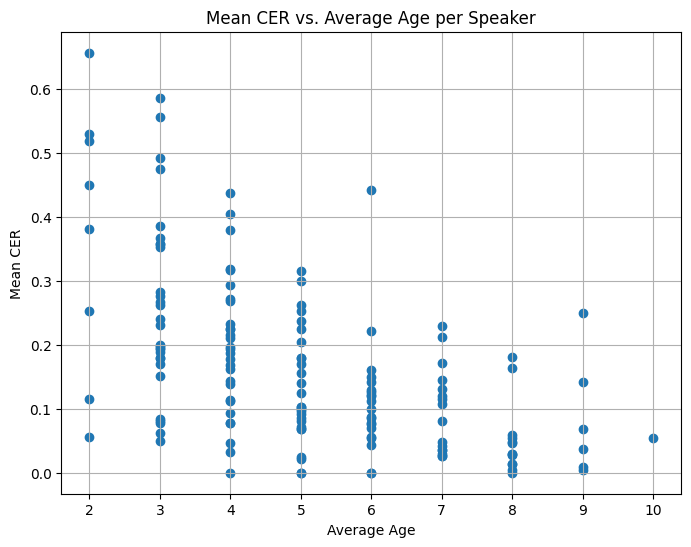

In [ ]:
meta_df = df.groupby('id').agg(
    count=('CER', 'count'),
    mean=('CER', 'mean'),
    age=('age', 'mean')  # add average age
)
import matplotlib.pyplot as plt
# Scatter plot: x = age, y = mean CER
plt.figure(figsize=(8, 6))
plt.scatter(meta_df['age'], meta_df['mean'])
plt.xlabel('Average Age')
plt.ylabel('Mean CER')
plt.title('Mean CER vs. Average Age per Speaker')
plt.grid(True)
plt.show()

In [ ]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'audio', 'disease_type', 'age', 'gender',
       'subgroup', 'id', 'textgrid_text', 'target_text', 'human_text',
       'asr_text', 'new_label', 'target_text_jamo', 'cer_word_baseline',
       'human_text_jamo', 'word_human_CER', 'word_target_CER',
       'asr_human_transcription', 'CER', 'pred_by_ASR', 'human_target_CER',
       'background'],
      dtype='object')

In [ ]:
df['id'].nunique()

150

x

In [ ]:
톤/피치 일치화

bias 애 대한 loss (Age classifier 더하기 / 나이별로 따로/ 발화자별 bias)


In [ ]:
cfm1 = [911, 1023, 490, 251]
cfm2 = [126, 1152, 203, 174]
sum  = []

# for i in range(len(cfm1)):
#     print(i)
#     sum.append(cfm1[i]+cfm2[i])

# sum = [cfm1[i]+cfm2[i] for i in range(len(cfm1))]
sum = [x + y for x,y in zip(cfm1,cfm2)]
print(sum)

tp = sum[0]
tn = sum[1]
fp = sum[2]
fn = sum[3]

sensitivity = tp / (tp + fn)
specificity = tn / (fp + tn)

uar = (specificity + sensitivity)/2.0
uar


[1037, 2175, 693, 425]


0.7338352632091077

In [ ]:
import pandas as pd

df =pd.read_csv('/data/selinawisco/kochild/r08.1_train.csv')
df['age'].nunique()

9

In [4]:
from sklearn.metrics import classification_report 
age_df = pd.read_csv('/home/selinawisco/asr_ssd_main/0421_44_eval.csv')
df_old = age_df[age_df['age']>5]
print(classification_report(df_old['new_label'], df_old['pred_by_ASR']))
df_old['pred_by_ASR'].value_counts()

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1355
           1       0.41      0.43      0.42       300

    accuracy                           0.78      1655
   macro avg       0.64      0.65      0.64      1655
weighted avg       0.79      0.78      0.79      1655



pred_by_ASR
0.0    1337
1.0     318
Name: count, dtype: int64

### age classifier 모델 성능 분석

In [5]:
from sklearn.metrics import classification_report 
age_df = pd.read_csv('/home/selinawisco/asr_ssd_main/0502_age_label_42_0.3_eval.csv')
df_old = age_df[age_df['age']>5]
print(classification_report(df_old['new_label'], df_old['pred_by_ASR']))
df_old['pred_by_ASR'].value_counts()

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1355
           1       0.39      0.41      0.40       300

    accuracy                           0.78      1655
   macro avg       0.63      0.64      0.63      1655
weighted avg       0.78      0.78      0.78      1655



pred_by_ASR
0.0    1337
1.0     318
Name: count, dtype: int64

### Age adversarial 모델 성능 분석

In [6]:
import pandas as pd
from sklearn.metrics import classification_report 
age_df = pd.read_csv('0502_age_label_adversarial_42_0.3_0.5_eval.csv')
df_old = age_df[age_df['age']>5]
print(classification_report(df_old['new_label'], df_old['pred_by_ASR']))
df_old['pred_by_ASR'].value_counts()


              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1355
           1       0.33      0.37      0.35       300

    accuracy                           0.75      1655
   macro avg       0.59      0.60      0.59      1655
weighted avg       0.76      0.75      0.75      1655



pred_by_ASR
0.0    1318
1.0     337
Name: count, dtype: int64

In [ ]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_colwidth', None)
df = pd.read_csv('0421_44_eval.csv')
view = df[df['new_label']!=df['pred_by_ASR']]
view = view[view['age']<=5]
view = view[['audio','pred_by_ASR','human_text']]
view.tail(30)

#### Loss Weighting

In [1]:
df = pd.read_csv('0502_age_label_age_loss_weighting_44_eval.csv')

old = df[df['age']>5]
print(classification_report(old['new_label'], old['pred_by_ASR']))

young = df[df['age']<=5]
print(classification_report(young['new_label'], young['pred_by_ASR']))

NameError: name 'pd' is not defined

In [8]:
old['pred_by_ASR'].value_counts()

pred_by_ASR
0.0    1278
1.0     377
Name: count, dtype: int64

In [ ]:
import pandas as pd
import librosa 

# df = pd.read_csv('/data/selinawisco/kochild/r08.1_train.csv')
df = pd.read_csv('/data/selinawisco/kochild/r08_APAC_KAPP_25_train.csv')

def dur(path):
    return librosa.get_duration(path=path)
df['duration'] = df['audio'].apply(dur)
sorted(df['duration'])

# pd.set_option('display.max_colwidth', None)
df[df['duration']==df['duration'].max()]

,audio,disease_type,new_label,gender,id,age,severity,textgrid_text,human_text,target_text,human_text_jamo,target_text_jamo,duration
6663,/data/selinawisco/kochild/KAPP_25/K_APP_25_wor...,0,1,male,392,7,0,에이비터(엘리베이터),에이비터,엘리베이터,ㅇㅔㅇㅣㅂㅣㅌㅓ,ㅇㅔㄹㄹㅣㅂㅔㅇㅣㅌㅓ,5.094376
6687,/data/selinawisco/kochild/KAPP_25/K_APP_25_wor...,0,1,male,392,7,0,에이비터(엘리베이터),에이비터,엘리베이터,ㅇㅔㅇㅣㅂㅣㅌㅓ,ㅇㅔㄹㄹㅣㅂㅔㅇㅣㅌㅓ,5.094376


In [8]:
print(len(df))
cols = [col for col in df.columns if col !='audio']
# pd.set_option('display.max_rows', None)
dups= df.groupby(cols).filter(lambda x: len(x) >1) #  cols의 각각의 value 가 다 같은 행끼리 묵고, 그 그룹이 1개 이상인 것만 남긴다 (중복 행만 선택)
dups.sort_values(by='duration')



7041


,audio,disease_type,new_label,gender,id,age,severity,textgrid_text,human_text,target_text,human_text_jamo,target_text_jamo,duration
4515,/data/selinawisco/kochild/KAPP_25/K_APP_25_wor...,0,0,female,390,6,0,입,입,입,ㅇㅣㅂ,ㅇㅣㅂ,0.148866
4532,/data/selinawisco/kochild/KAPP_25/K_APP_25_wor...,0,0,female,390,6,0,입,입,입,ㅇㅣㅂ,ㅇㅣㅂ,0.148866
4728,/data/selinawisco/kochild/KAPP_25/K_APP_25_wor...,0,0,female,863,7,0,별,별,별,ㅂㅕㄹ,ㅂㅕㄹ,0.159909
4708,/data/selinawisco/kochild/KAPP_25/K_APP_25_wor...,0,0,female,863,7,0,별,별,별,ㅂㅕㄹ,ㅂㅕㄹ,0.159909
1816,/data/selinawisco/kochild/KAPP_25/K_APP_25_wor...,0,0,male,621,3,0,학,학,학,ㅎㅏㄱ,ㅎㅏㄱ,0.169660
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6659,/data/selinawisco/kochild/KAPP_25/K_APP_25_wor...,0,1,male,392,7,0,크레파트(크레파스),크레파트,크레파스,ㅋㅡㄹㅔㅍㅏㅌㅡ,ㅋㅡㄹㅔㅍㅏㅅㅡ,4.443061
6686,/data/selinawisco/kochild/KAPP_25/K_APP_25_wor...,0,1,male,392,7,0,미끄너틀(미끄럼틀),미끄너틀,미끄럼틀,ㅁㅣㄲㅡㄴㅓㅌㅡㄹ,ㅁㅣㄲㅡㄹㅓㅁㅌㅡㄹ,4.937460
6662,/data/selinawisco/kochild/KAPP_25/K_APP_25_wor...,0,1,male,392,7,0,미끄너틀(미끄럼틀),미끄너틀,미끄럼틀,ㅁㅣㄲㅡㄴㅓㅌㅡㄹ,ㅁㅣㄲㅡㄹㅓㅁㅌㅡㄹ,4.937460
6663,/data/selinawisco/kochild/KAPP_25/K_APP_25_wor...,0,1,male,392,7,0,에이비터(엘리베이터),에이비터,엘리베이터,ㅇㅔㅇㅣㅂㅣㅌㅓ,ㅇㅔㄹㄹㅣㅂㅔㅇㅣㅌㅓ,5.094376


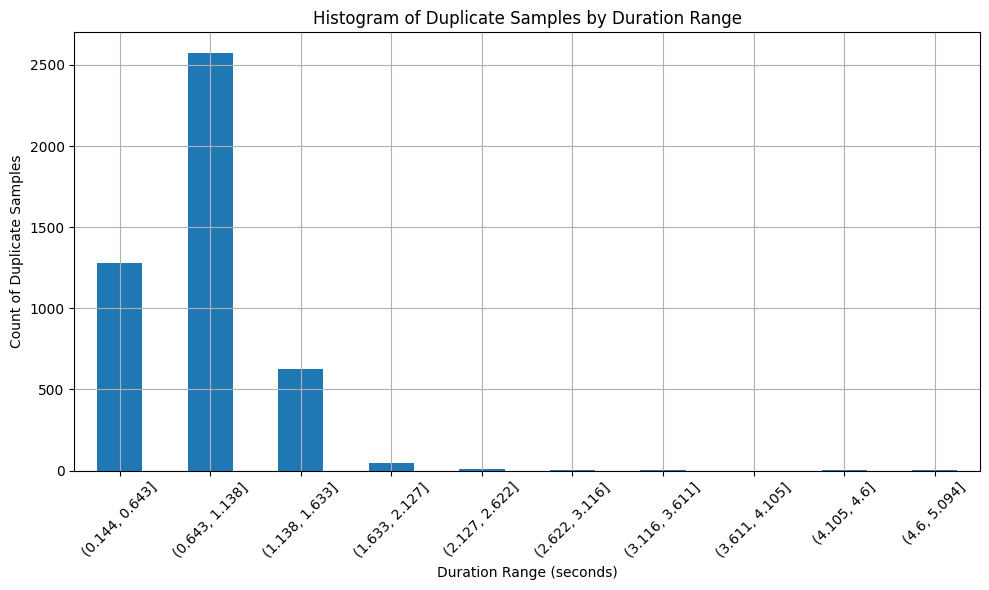

In [5]:
import matplotlib.pyplot as plt
if not dups.empty:
    dups['duration_bin'] = pd.cut(dups['duration'], bins=10)
    duration_counts = dups['duration_bin'].value_counts().sort_index()

    plt.figure(figsize=(10, 6))
    duration_counts.plot(kind='bar')
    plt.xlabel('Duration Range (seconds)')
    plt.ylabel('Count of Duplicate Samples')
    plt.title('Histogram of Duplicate Samples by Duration Range')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()
else:
    print("No duplicate rows found excluding 'audio' column.")
